# Grid Cell Phase Coding 

Phases are in radians, coordinates are in [m] and time base is [ms].
The first data point in XYspkT corresponds with the first spike, which also corresponds with the first phase value and so on. So those files should have the same number of rows and if you merge them as columns each row should correspond with the same spike event.
So here is an important detail to pay attention to. __Because the spike times in the file are not in an ascending order but in the order of cells combined (like cell1 t1, cell1 t2, cell1 t3,..., cell2 t1, cell2 t2, cell2 t3,...)  if you sort them you will need to reindex the XYspkT and Phase data too.__
Or you just leave them as they are. Then they remain aligned.
 
The ultimate task is to predict the place where the avatar goes next based on the phase of the next spike. We have all the info we need. We know where the avatar is in space (X,Y), we know the phase of the next spike and we know the average map of all phases. We just need to find where the next spike would best fit on that map of opportunities based on average phases. Because average phases tessellate like grids, therefore for a given spike phase there are multiple spots in the field where that spike can ideally land. Of course the real landing spot is  one that is nearby, since the avatar does not jump. So we need to look the map of average phases at the local neighborhood and find the best match between the actual phase and the average phase map. The vector between the avatar's actual position and the predicted position (i.e the position where the phase of next spike would best match) defines a vector of moving direction. These are the small arrows in my plot.

An example:  
Let say the spike that just happened at t0 was generated at 30 degree (0.5236 rad) of the ongoing gamma cycle. We know the avatar's spatial position (X,Y). We also know that next spike t1 will be generated at 45 degree but we don't know at what spatial position. So we are considering the next 6 spikes (where 6 is an arbitrary number)  or a 5 x 5 m area around the spike (where 5 is an arbitrary metric) and try to find a tile with the average phase that best fit to the phase of next spike. That tile would be our best guess for the next position of the avatar.
The figure I will send next illustrates these steps. You see the trajectory in grey, the movement segments in blue. The hairy graph is the predicted direction. Each small linelet is a predicted direction, sometimes aligne sometimes don't. The last two plots are the direction angle difference between predicted and actual movement directions and the matrix of decoding performance, i.e. the correlation between observed and predicted direction angles.

Of course, for a cross-validation purpose, we will need to divide the data into a training set and decoding set (or predicting set). That will be the second step. (I did that and got some nice results.) But for start, let's just try to decode the phase using the entire 5 min data.

In [289]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#%matplotlib inline
np.set_printoptions(suppress=True)
%config InLineBackend.figure_format = 'retina'

## XYspktT

XYspktT contains the X,Y coordinates of spikes. Spikes from all 30 neurons are combined in a single spike train. The X and Y columns represent the avatar's X-Y coordinate in [m] relative to the environment at the moment of the spike. 

[[17.807  44.0128]
 [18.15   43.9968]
 [53.527  46.4516]
 ...
 [17.708  41.7265]
 [53.349  45.8657]
 [55.03   45.4198]]


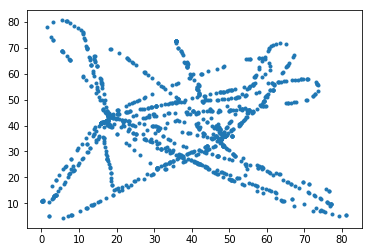

In [290]:
XYspkT = np.loadtxt('XYspkT.csv',delimiter=',')+40
print(XYspkT)

plt.plot(XYspkT[:,0],XYspkT[:,1],'.')

## spkT

spkT contains the times of the spikes in ms

In [291]:
spkT = np.loadtxt('spkT.csv',delimiter=',')
print(spkT)
spkT.shape

[ 27466.  29501.  36602. ... 288400. 295600. 297440.]


(1178,)

## Phase

Phase is the corresponding (gamma) phase of the spikes - what phase the gamma oscillation was at them moment of spike

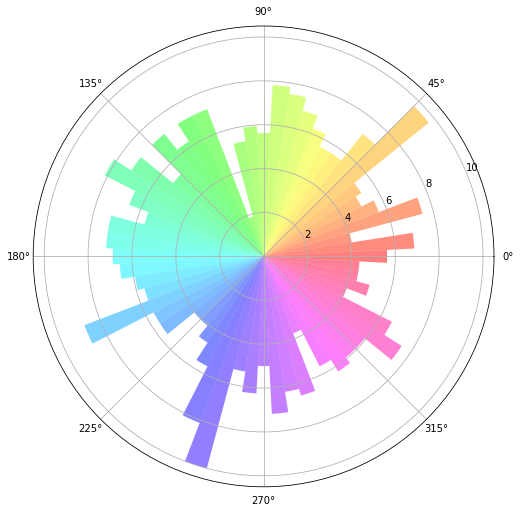

In [292]:
phase = np.loadtxt('Phase.csv',delimiter=',')
phase_degrees = np.degrees(phase)
sorted_phase = np.sort(phase_degrees)


#Radial histogram of phase distribution
#https://matplotlib.org/examples/pie_and_polar_charts/polar_bar_demo.html
fig = plt.figure(figsize=(8,8))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], polar=True)
theta = np.radians(np.arange(0,366,6))

inds = [np.where(sorted_phase<i)[0][-1] for i in np.arange(6,366,6)] #vectorize operation?
b = np.split(sorted_phase,inds)
radii = np.array([i.size/3.2 for i in b])

width = np.radians(360/60)
bars = ax.bar(theta, radii, width=width, bottom=0.0)
for theta, bar in zip(theta, bars):
    bar.set_facecolor(plt.cm.hsv(theta/6.28))
    bar.set_alpha(0.5)

plt.show()

## MeanPhaseMap

MeanPhaseMap the map of gamma phases. This is a 40x43 matrix that represents the 80x86 m land of the desert, the area covered by the avatar's navigation. The lot of NaN data correspond with areas never visited. A given value at the n-th row and m-th column represents the average phase of spikes (all spikes) within that area during the entire 5 min navigation. 

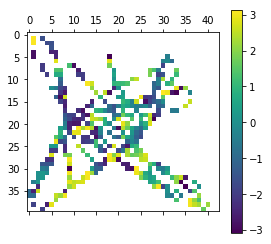

In [293]:
raw = np.loadtxt('MeanPhaseMap.csv',delimiter=',')

#Flipping to match the other plots and stripping erraneous values bordering the top row and right column
MeanPhaseMap = np.flip(raw,axis=0)
MeanPhaseMap[0] = 'NaN'
MeanPhaseMap[:,42] = 'Nan'

plt.matshow(MeanPhaseMap)
plt.colorbar()

## Binned Phase Map / Single Unit Simulation

/home/daniel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


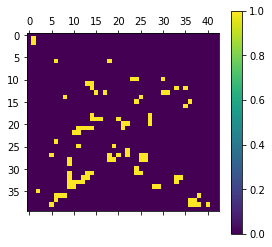

In [294]:
MPM3 = np.zeros((40,43))
MPM3[np.where(MeanPhaseMap>2)[0],np.where(MeanPhaseMap>2)[1]]=1
MPM3


plt.matshow(MPM3)
plt.colorbar()

/home/daniel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


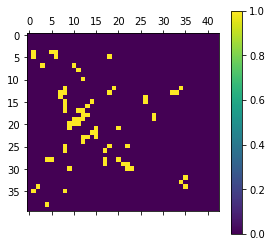

In [295]:
MPM2 = np.zeros((40,43))
MPM2[np.where(MeanPhaseMap<-2)[0],np.where(MeanPhaseMap<-2)[1]]=1
MPM2


plt.matshow(MPM2)
plt.colorbar()

## xyPos
xyPos is the trajectory traveled by the avatar. Each row is an X-Y data pair in [m] sampled in every ms. It is the biggest file because of the density of points. You can down-sample it to make it more manageable.

[[31.0183  38.1906 ]
 [31.0183  38.1906 ]
 [31.0183  38.1906 ]
 ...
 [52.56    39.68139]
 [52.502   39.57129]
 [52.443   39.46164]]


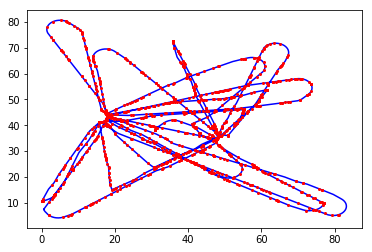

In [296]:
xyPos = np.loadtxt('xyPos.csv',delimiter=',')[::25]+40
print(xyPos)

#Trajectory overlaid with XYspkT
plt.plot(xyPos[:,0],xyPos[:,1], color='b')
plt.plot(XYspkT[:,0],XYspkT[:,1], '.', color='r', markersize=4)

## Combined Position, Time and Phase DataFrame

X,Y position, change in distance, time and phase data sorted by trajectory from the Time column in a dataframe

In [301]:
xdif = np.insert(XYspkT[1:,0]-XYspkT[:-1,0],0,0)
ydif = np.insert(XYspkT[1:,1]-XYspkT[:-1,1],0,0)
change = np.sqrt(xdif**2+ydif**2)

combined = np.column_stack((spkT,XYspkT,change,phase))
df = pd.DataFrame(data=combined, columns=['Time','X','Y','Change (Distance)','Phase'])
ordered_df = df.sort_values(by=['Time'])
ordered_df

,Time,X,Y,Change (Distance),Phase
612,16.0,31.01830,38.19060,22.404053,4.62390
613,127.0,31.01830,38.19060,0.000000,5.06930
170,133.0,31.01830,38.19060,12.205134,5.98280
930,161.0,31.01830,38.19060,25.091243,3.91570
138,275.0,31.01830,38.19060,25.076345,6.05060
661,863.0,31.38080,38.81530,24.863512,2.07420
368,907.0,31.50160,38.99960,11.149629,3.14880
662,1495.0,33.47020,40.96653,2.998897,0.73805
199,1950.0,35.47850,41.93030,17.383938,1.51490
103,2099.0,36.21900,41.95060,19.412304,5.03900


## Ordered Combined Data

The same X,Y position, time and phase data sorted by trajectory from the Time column

In [304]:
phase_df = pd.DataFrame(data=MeanPhaseMap, columns=np.arange(43))
phase_df

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,3.08440,NaN,-1.56840,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,3.08440,NaN,NaN,-1.683700,-1.576300,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,-1.508800,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,-2.84580,NaN,NaN,NaN,-2.508200,-2.50820,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,-2.84580,NaN,NaN,NaN,NaN,-2.47300,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,2.84150,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,-2.03110,NaN,NaN,NaN,NaN,NaN,1.2731,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,-1.96730,NaN,NaN,1.39460,1.39460,NaN,NaN,...,1.7291,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,-1.949400,NaN,0.74374,0.74374,NaN,NaN,...,1.0954,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [319]:
def adjacent_matrix(cell):
    #Find more elegant way to do this ~
    
    a = np.zeros((5,5))
    c_x = cell[0]
    c_y = cell[1]
    
    a[0,0] = phase_df.iloc[c_x-2,c_y-2]
    a[0,1] = phase_df.iloc[c_x-2,c_y-1]
    a[0,2] = phase_df.iloc[c_x-2,c_y]
    a[0,3] = phase_df.iloc[c_x-2,c_y+1]
    a[0,4] = phase_df.iloc[c_x-2,c_y+2]
    
    a[1,0] = phase_df.iloc[c_x-1,c_y-2]
    a[1,1] = phase_df.iloc[c_x-1,c_y-1]
    a[1,2] = phase_df.iloc[c_x-1,c_y]
    a[1,3] = phase_df.iloc[c_x-1,c_y+1]
    a[1,4] = phase_df.iloc[c_x-1,c_y+2]

    a[2,0] = phase_df.iloc[c_x,c_y-2]
    a[2,1] = phase_df.iloc[c_x,c_y-1]
    a[2,2] = phase_df.iloc[c_x,c_y]
    a[2,3] = phase_df.iloc[c_x,c_y+1]
    a[2,4] = phase_df.iloc[c_x,c_y+2]
    
    a[3,0] = phase_df.iloc[c_x+1,c_y-2]
    a[3,1] = phase_df.iloc[c_x+1,c_y-1]
    a[3,2] = phase_df.iloc[c_x+1,c_y]
    a[3,3] = phase_df.iloc[c_x+1,c_y+1]
    a[3,4] = phase_df.iloc[c_x+1,c_y+2]
    
    a[4,0] = phase_df.iloc[c_x+2,c_y-2]
    a[4,1] = phase_df.iloc[c_x+2,c_y-1]
    a[4,2] = phase_df.iloc[c_x+2,c_y]
    a[4,3] = phase_df.iloc[c_x+2,c_y+1]
    a[4,4] = phase_df.iloc[c_x+2,c_y+2]
    
    return a

adjacent_matrix([31,2])
    

array([[       nan,        nan,        nan, -1.4318   , -1.4561   ],
       [       nan,        nan,        nan, -0.49505  , -0.68655  ],
       [       nan,        nan,  0.040979 ,  0.21299  , -0.036272 ],
       [       nan,        nan, -0.0011882,  0.2238   ,        nan],
       [       nan, -0.40405  ,  0.17614  ,        nan,        nan]])